# Assess the identified markers

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

#from rdea.eval.cross_validation import do_cross_validation, do_cross_validation_with_feature_selection
from rdea.eval.evaluate import do_train_test
from rdea.filters.embedded import EmbeddedFilter
from rdea.filters.mrmr import MRMRP
from rdea.utils.help_functions import model_based_relevance, auc_relevance, load_DEGs


import matplotlib.pyplot as plt
%matplotlib inline   
import seaborn as sns
import warnings

# Comment these lines if you are not using Mac OS
import matplotlib as mpl
#mpl.use('MacOSX')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set random seed
seed = 7
np.random.seed(seed)

## Inputs and parameters

In [2]:
# ========== INPUTS ==========
mydata = 'GSE64810'
# in and out files
data_file = 'data/'+ mydata +'_Train.csv'
markers_file = 'results/fs_scores.csv'
test_file = 'data/'+ mydata +'_Test.csv'
degs_file =  'data/'+ mydata +'_NEWDEGs.txt'

is_save_results = True

# data pre-processing
is_normalize_samples = False
is_normalize_columns = True
norm_filter = MinMaxScaler()

# experiment
label = 'disease'

# No of markers
min_markers = 1
max_markers = 10

# classifiers
models = [
  ('RF', RandomForestClassifier(n_estimators=100,  random_state=seed)),
  ('LR', SGDClassifier(loss="log", penalty="l2", random_state=seed)),
  ('XGB', XGBClassifier(objective="binary:logistic", n_estimators=100, n_jobs=4, random_state=seed)),
 ]


<hr>
<b>Do not modify the code below this line.</b><br>
<hr>

In [14]:
# load markers 

markers_df = pd.read_csv(markers_file)
markers_df.feature = markers_df.feature.astype(str)


features = markers_df['feature'].values

print('{} markers loaded!'.format(len(features)))

markers_sets = []
for i in range(min_markers,max_markers+1):
    markers_sets.append(('top_'+str(i),features[:i]))

30 markers loaded!


In [15]:
markers_df

,feature,score
0,10590,0.75
1,2255,0.50
2,168090,0.50
3,126695,0.50
4,105375370,0.50
5,105374443,0.50
6,60675,0.50
7,158062,0.50
8,387700,0.50
9,221074,0.25


In [16]:
# Load data 
df = pd.read_csv(data_file)
df=df.set_index('SID')
df = df.transpose()
print('Shape of {0} is {1}'.format(data_file, df.shape))
y_train = df[label]

Shape of data/GSE64810_Train.csv is (69, 22094)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# Load test data 
df_test = pd.read_csv(test_file,dtype={'SID':str})
df_test=df_test.set_index('SID')
df_test = df_test.transpose()

print('Shape of {0} is {1}'.format(test_file, df_test.shape))
y_test = df[label]

Shape of data/GSE64810_Test.csv is (69, 22094)


In [31]:
markers_sets

[('top_1', array(['10590'], dtype=object)),
 ('top_2', array(['10590', '2255'], dtype=object)),
 ('top_3', array(['10590', '2255', '168090'], dtype=object)),
 ('top_4', array(['10590', '2255', '168090', '126695'], dtype=object)),
 ('top_5',
  array(['10590', '2255', '168090', '126695', '105375370'], dtype=object)),
 ('top_6',
  array(['10590', '2255', '168090', '126695', '105375370', '105374443'],
        dtype=object)),
 ('top_7',
  array(['10590', '2255', '168090', '126695', '105375370', '105374443',
         '60675'], dtype=object)),
 ('top_8',
  array(['10590', '2255', '168090', '126695', '105375370', '105374443',
         '60675', '158062'], dtype=object)),
 ('top_9',
  array(['10590', '2255', '168090', '126695', '105375370', '105374443',
         '60675', '158062', '387700'], dtype=object)),
 ('top_10',
  array(['10590', '2255', '168090', '126695', '105375370', '105374443',
         '60675', '158062', '387700', '221074'], dtype=object))]

## Searching for optimal model

Performance reported using:	 ACC	Sn	Sp	MCC	AUC
top_1: ['10590']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
RF: [1. 1. 1. 1. 1.]
top_2: ['10590' '2255']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
RF: [1. 1. 1. 1. 1.]
top_3: ['10590' '2255' '168090']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
RF: [1. 1. 1. 1. 1.]
top_4: ['10590' '2255' '168090' '126695']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
RF: [1. 1. 1. 1. 1.]
top_5: ['10590' '2255' '168090' '126695' '105375370']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
RF: [1. 1. 1. 1. 1.]
top_6: ['10590' '2255' '168090' '126695' '105375370' '105374443']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
RF: [1. 1. 1. 1. 1.]
top_7: ['10590' '2255' '168090' '126695' '105375370' '105374443' '60675']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
RF: [1. 1. 1. 1. 1.]
top_8: ['10590' '2255' '168090' '126695' '105375

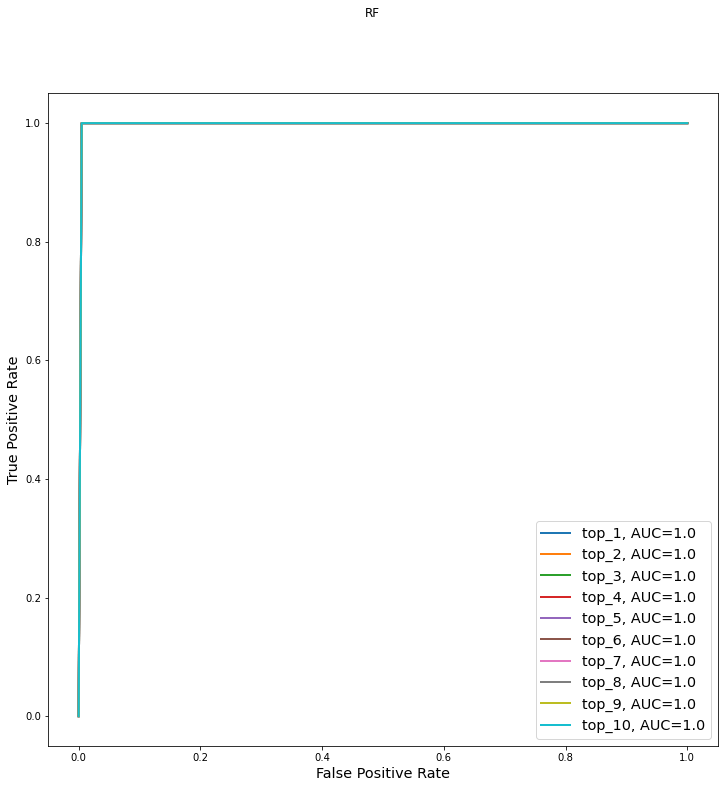

top_1: ['10590']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
LR: [0.31884058 0.95       0.06122449 0.02179179 0.68469388]
top_2: ['10590' '2255']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
LR: [0.31884058 0.95       0.06122449 0.02179179 0.68469388]
top_3: ['10590' '2255' '168090']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
LR: [0.31884058 0.95       0.06122449 0.02179179 0.68469388]
top_4: ['10590' '2255' '168090' '126695']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
LR: [0.31884058 0.95       0.06122449 0.02179179 0.68469388]
top_5: ['10590' '2255' '168090' '126695' '105375370']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
LR: [0.31884058 0.95       0.06122449 0.02179179 0.68469388]
top_6: ['10590' '2255' '168090' '126695' '105375370' '105374443']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
LR: [0.31884058 0.95       0.06122449 0.02179179 0.68469388]
top_7: ['10590

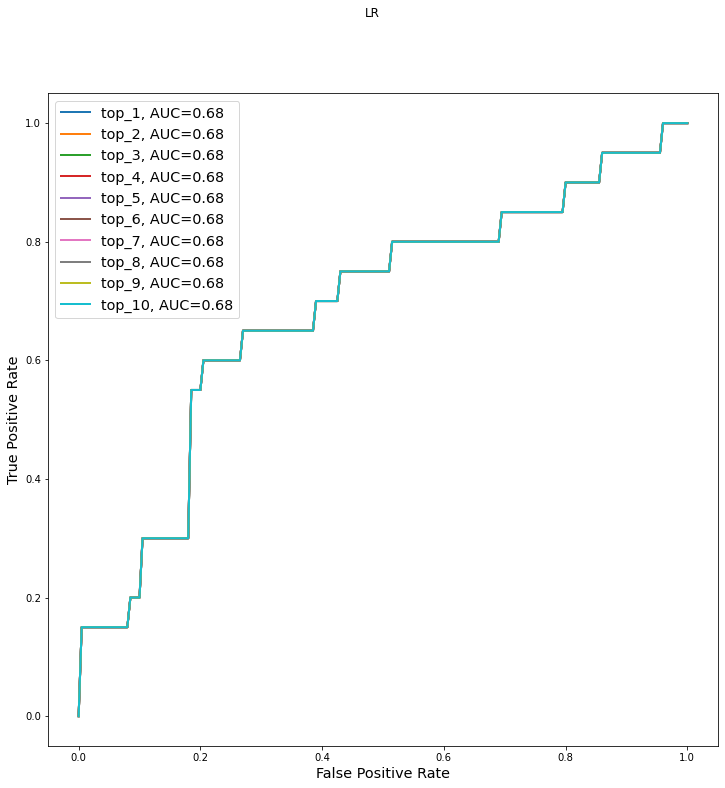

top_1: ['10590']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
[19:17:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: [1. 1. 1. 1. 1.]
top_2: ['10590' '2255']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
[19:17:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: [1. 1. 1. 1. 1.]
top_3: ['10590' '2255' '168090']
Shape of training data is (69, 2)
Shape of test data is (69, 2)
[19:17:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the 

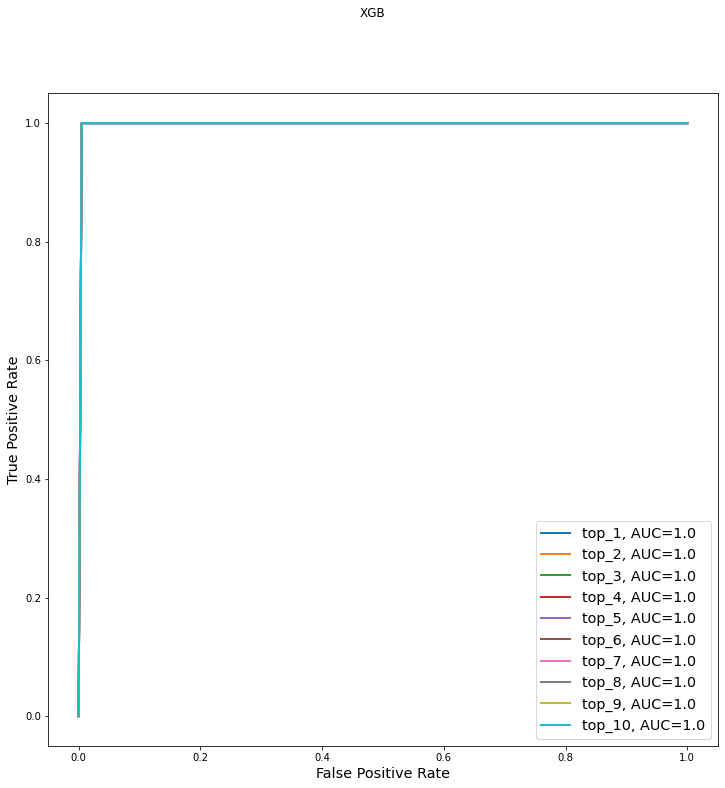

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Performance reported using:\t ACC\tSn\tSp\tMCC\tAUC')



    for model in models:
        plt.figure(figsize=(12, 12))
        plt.xlabel('False Positive Rate', fontsize='x-large')
        plt.ylabel('True Positive Rate', fontsize='x-large')

        for markers in markers_sets:
            print('{0}: {1}'.format(markers[0], markers[1]))
            markers[1]
            #new_df = df[markers[1]].copy()
            #new_df = df.iloc[:,markers[1]].copy()
            X_train = new_df.values
            #new_df_test = df_test[markers[1]].copy()
            #new_df_test = df_test.iloc[:,markers[1]].copy()
            X_test = new_df_test.values
            # Normalize per sample?
            if is_normalize_samples:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train.T, y_train).T
                X_test = minMax_filter.transform(X_test)
            # Normalize per column?
            if is_normalize_columns:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train, y_train)
                X_test = minMax_filter.transform(X_test)

            print('Shape of training data is {}'.format(np.shape(X_train)))
            print('Shape of test data is {}'.format(np.shape(X_test)))


            res = do_train_test(X_train, y_train, X_test, y_test, model=model[1], fs_model=None)
            print('{0}: {1}'.format(model[0], res['metrics']))
            plt.plot(res['fpr'], res['tpr'], label=markers[0]+', AUC='+str(round(res['metrics'][4],2)), linewidth=2)

        leg = plt.legend(loc='best', fontsize='x-large')
        plt.suptitle(model[0])
        print('----------------------------------------------------------------------------------------------------')
        plt.show()



We noted that the best performance is obrained using LR classifier and top2 markers.

## ROC for different classifiers using the optimal number of markers

In [ ]:
markers_sets =[('top_3',features[:3])]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    plt.figure(figsize=(12, 12))
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')


    for model in models:
        for markers in markers_sets:
            print('{0}: {1}'.format(markers[0], markers[1]))
            new_df = df.iloc[:,markers[1]].copy()
            X_train = new_df.values
            new_df_test = df_test.iloc[:,markers[1]].copy()
            X_test = new_df_test.values
            # Normalize per sample?
            if is_normalize_samples:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train.T, y_train).T
                X_test = minMax_filter.transform(X_test)
            # Normalize per column?
            if is_normalize_columns:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train, y_train)
                X_test = minMax_filter.transform(X_test)

            print('Shape of training data is {}'.format(np.shape(X_train)))
            print('Shape of test data is {}'.format(np.shape(X_test)))


            res = do_train_test(X_train, y_train, X_test, y_test, model=model[1], fs_model=None)
            print('{0}: {1}'.format(model[0], res['metrics']))
            plt.plot(res['fpr'], res['tpr'], label=model[0]+', AUC='+str(round(res['metrics'][4],2)), linewidth=2)

    leg = plt.legend(loc='lower right', fontsize='x-large')
    #plt.suptitle(target_model[0])
    plt.show()

## Performance of final model using different choices of the threshold for binarizing the predictions

In [ ]:
model = ('LR', SGDClassifier(loss="log", penalty="l2", random_state=seed))
#model = ('RF', RandomForestClassifier(n_estimators=100,  random_state=seed))
markers_sets =[('top_3',features[:3])]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    print('ACC\tSn\tSp\tMCC\tAUC')
    for thrd in range(0,101,2):
        for markers in markers_sets:
            new_df = df.iloc[:,markers[1]].copy()
            X_train = new_df.values
            new_df_test = df_test.iloc[:,markers[1]].copy()
            X_test = new_df_test.values
            # Normalize per sample?
            if is_normalize_samples:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train.T, y_train).T
                X_test = minMax_filter.transform(X_test)
             # Normalize per column?
            if is_normalize_columns:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train, y_train)
                X_test = minMax_filter.transform(X_test)

            res = do_train_test(X_train, y_train, X_test, y_test, model=model[1], fs_model=None,  threshold=thrd/100.0)
            print('{0}: {1}'.format(thrd/100.0, res['metrics']))


- The highest MCC of 0.38 is reached using threshold = 0.58
- Sp of 0.9 is reached using threshold = 0.60
- Sp of 0.95 is reached using threshold = 0.74

## Final model vs model using all DEGs

In [ ]:
# load DEGs if provided
if degs_file is not None:
    DEGs = load_DEGs(degs_file)
    print('{} DEGs loaded!'.format(len(DEGs)))
else:
    print('No DEGs provided.')

In [ ]:
top3_ml = features[:3]
markers_sets =[
               ('top3_ml', top3_ml),
               ('DEGs', DEGs)
]
models = [
  ('LR', SGDClassifier(loss="log", penalty="l2", random_state=seed)),
 ]


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    plt.figure(figsize=(12, 12))
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')


    for model in models:
        for markers in markers_sets:
            print('{0}: {1}'.format(markers[0], markers[1]))
            new_df = df.iloc[:,markers[1]].copy()
            X_train = new_df.values
            new_df_test = df_test.iloc[:,markers[1]].copy()
            X_test = new_df_test.values
            # Normalize per sample?
            if is_normalize_samples:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train.T, y_train).T
                X_test = minMax_filter.transform(X_test)
            # Normalize per column?
            if is_normalize_columns:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train, y_train)
                X_test = minMax_filter.transform(X_test)

            print('Shape of training data is {}'.format(np.shape(X_train)))
            print('Shape of test data is {}'.format(np.shape(X_test)))


            res = do_train_test(X_train, y_train, X_test, y_test, model=model[1], fs_model=None)
            print('{0}: {1}'.format(model[0], res['metrics']))
            plt.plot(res['fpr'], res['tpr'], label=markers[0]+', AUC='+str(round(res['metrics'][4],2)), linewidth=2)

    leg = plt.legend(loc='lower right', fontsize='x-large')
    #plt.suptitle(target_model[0])
    plt.show()

We note that, for specificity > 0.8, the LR model using only top 3 marker genes has a better sensitivity than the LR model trained using all DEGs.